# Analyse % nuages avec les fichiers Full-Resolution Browse Landsat C2 L1

Le site <https://earthexplorer.usgs.gov/> permet de rechercher et télécharger des données d'aperçu en pleine résolution (30 m.) pour les produits Landsat C2 L1. Un aperçu en couleur naturelle est disponible, ainsi qu'un masque 8 bits. Les fichiers d'aperçus sont distribués au format GeoTIFF ce qui permet de les utiliser dans QGIS, et pèsent généralement 2 à 3 Mo.

Voir **cette page** pour la documentation des aperçus en pleine résolution : <https://www.usgs.gov/landsat-missions/landsat-collection-2-full-resolution-browse-images>

Le script Python qui suit montre comment tirer parti du masque 8 bits pour calculer le % de nuages sur une zone d'études.

Nous avons téléchargé les données pour 8 sites d'études :

- Georgetown
- Corriverton_NNickerie
- Paramaribo
- Albina_StLaurentDuMaroni
- Kourou
- Cayenne
- StGeorges_Oiapoque
- Macapa

Dans chaque site d'étude nous avons 3 datasets (capteur) :

- Landsat 4-5 TM C2 L1
- Landsat 7 ETM_ C2 L1
- Landsat 8 OLI_TIRS C2 L1

Pour chaque dataset, nous avons téléchargé les données suivantes :

- Full-Resolution Browse (Natural Color) GeoTIFF, `*_refl_tif.tif`
- Full-Resolution Browse (Quality) GeoTIFF, `*_qb_tif`


L'algorithme mis en oeuvre sera le suivant :

### Lire les fichiers d'emprises (KMZ)

In [1]:
# fonction pour lire l'emprise d'une zone d'étude (.kmz)
# on suppose que le fichier ne contient qu'un seul polygone
import geopandas as gpd

# Activer fiona driver pour KML / KMZ
gpd.io.file.fiona.drvsupport.supported_drivers["LIBKML"] = 'r'

def lire_kmz(path_kmz):
    gdf = gpd.read_file(path_kmz, driver='LIBKML')
    return gdf.geometry

geom_stlaurent_albina = lire_kmz("../KML_Progysat/Prog_Dinamis/St-Laurent-Du-Maroni_Albina.kmz")
geom_stlaurent_albina


0    POLYGON Z ((-54.05343 5.40050 0.00000, -54.051...
Name: geometry, dtype: geometry

### Extraire une fenêtre correspondant à l'emprise

Nous lisons les métadonnées du raster, et extrayons les informations du nom de fichier. 

In [2]:
# fonction pour lire les propriétés d'une image '_qb.tif'
# et calculer le % nuages

import numpy as np
import rasterio
from os.path import join, basename

def attr_qb(path_tif):
    with rasterio.open(path_tif) as src:
        dict_qb = src.meta.copy()
    nom_fichier = basename(path_tif)
    l_nom = nom_fichier.split('_')
    dict_qb.update({
        'sensor': l_nom[0],
        'geom_proc_level': l_nom[1],
        'pathrow': l_nom[2],
        'date': l_nom[3]
    })
    return dict_qb

f_test_qb = ("../Preview_Landsat/FullRes Browse/"
             "Bulk Order Albina SaintLaurentDuMaroni/"
             "Landsat 8 OLI_TIRS C2 L1/"
             "LC08_L1TP_228056_20130714_20200912_02_T1_qb.tif")
    #mask_bit = np.bitwise_and(b, compare_mask)
d_qb = attr_qb(f_test_qb)
d_qb

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 7561,
 'height': 7731,
 'count': 1,
 'crs': CRS.from_epsg(32621),
 'transform': Affine(30.0, 0.0, 710985.0,
        0.0, -30.0, 755715.0),
 'sensor': 'LC08',
 'geom_proc_level': 'L1TP',
 'pathrow': '228056',
 'date': '20130714'}

Nous calculons la position de la fenêtre à extraire dans le raster : celle-ci correspondra à la zone urbaine définie par le fichier KMZ + une zone tampon de 5000 mètres, dans le CRS de l'image Landsat (projection UTM).

In [3]:
# reprojeter le polygone en espg 32621
geom_utm = geom_stlaurent_albina.to_crs(d_qb['crs'])
# limites du buffer 5000 m ?
bounds_geom_utm = geom_utm.buffer(5000).total_bounds
# position et dimension fenetre, arrondi
win_geom_utm = rasterio.windows.from_bounds(*bounds_geom_utm, transform=d_qb['transform'])
win_geom_utm = win_geom_utm.round_offsets().round_lengths()
win_geom_utm

Window(col_off=3411, row_off=4565, width=864, height=896)

<AxesSubplot:>

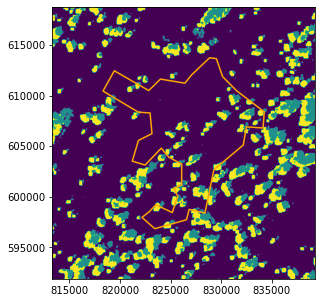

In [4]:
# extraire donnee fenetre
with rasterio.open(f_test_qb) as src:
    w = src.read(1, window=win_geom_utm)
    win_transform = src.window_transform(win_geom_utm)

# aperçu graphique
import rasterio.plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))
rasterio.plot.show(w, transform=win_transform, ax=ax)
geom_utm.boundary.plot(ax=ax, color="orange")

### Obtenir un masque raster et l'appliquer aux données nuages

Nous avons maintenant les données raster issues de la fenêtre ainsi que le contour de la zone urbaine. Pour calculer le % de nuages, la solution la plus efficace est de **rastériser** la zone urbaine, et de l'utiliser comme masque inversé (masquer tous les pixels en dehors de la zone urbaine). La dernière étape sera d'appliquer un masque binaire et calculer les statistiques de la zone non masquée.

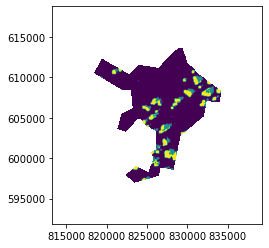

<AxesSubplot:>

In [5]:
# rasteriser zone urbaine
from rasterio import features
import numpy.ma as ma
mask_zu = features.rasterize(
    geom_utm,
    out_shape=w.shape,
    fill=1,
    transform=win_transform,
    all_touched=True,
    default_value=0,
    dtype=np.uint8
)

# masquer raster qb
mw = ma.masked_array(w, mask=mask_zu)
rasterio.plot.show(mw, transform=win_transform)


### Compter les valeurs

In [6]:
ma_values, values_counts = np.unique(mw, return_counts=True)
values = ma_values.compressed()
values_counts = values_counts[~ma_values.mask]


In [7]:
# renvoie indices 
def apply_binary_mask(values, compare_mask):
    """Compte le nombre total de valeurs correspondant au masque binaire"""
    values2 = np.bitwise_and(values, compare_mask)
    return (values2!=0)

test = np.array([0, 3, 8, 18, 24, 25], dtype=np.uint8)
apply_binary_mask(test, 0b00011000)

array([False, False,  True,  True,  True,  True])

In [8]:
is_cloud_shadow = apply_binary_mask(values, 0b00011000)
nb_pixels_cloud_shadow = np.sum(values_counts[is_cloud_shadow])
nb_pixels_data= np.sum(values_counts)

print(f"% pixels nuages et ombres = {nb_pixels_cloud_shadow} / {nb_pixels_data}")


% pixels nuages et ombres = 16938 / 128989


### Récap : une fonction pour la surface de nuages

Incluons tout ce que nous avons vu dans une fonction qui calcule le % de nuages : calcul et extraction de la fenêtre, rastérisation de la zone urbaine, Le calcul de pixels nuages et ombres. Cette fonction prendra comme paramètres : 

- le chemin d'accès du raster
- la géométrie de la zone urbaine, qui définit le masque
- les limites géographiques de la fenêtre de données

Elle retournera un tuple avec : (nb de pixels nuages et ombres, nb de pixels total dans la zone analysée).

In [23]:
# fonction : calcul nb pixel nuages et ombres
def calc_p_nuages(path_tif, geom_utm, bounds_geom_utm):
    # extraire donnee fenetre
    with rasterio.open(path_tif) as src:
        src_transform = src.transform
        # position et dimension fenetre
        win_geom_utm = rasterio.windows.from_bounds(*bounds_geom_utm, src_transform)
        win_geom_utm = win_geom_utm.round_offsets().round_lengths()
        w = src.read(1, window=win_geom_utm)
        win_transform = src.window_transform(win_geom_utm)
    # rasterisation
    mask_zu = features.rasterize(
        geom_utm,
        out_shape=w.shape,
        fill=1,
        transform=win_transform,
        all_touched=True,
        default_value=0,
        dtype=np.uint8
    )
    # masquer raster qb
    mw = ma.masked_array(w, mask=mask_zu)
    ma_values, values_counts = np.unique(mw, return_counts=True)
    values = ma_values.compressed()
    values_counts = values_counts[~ma_values.mask]
    is_cloud_shadow = apply_binary_mask(values, 0b00011000)
    nb_pixels_cloud_shadow = np.sum(values_counts[is_cloud_shadow])
    nb_pixels_data= np.sum(values_counts)
    return ({
        'surf_nuage': nb_pixels_cloud_shadow, 
        'surf_total': nb_pixels_data})

calc_p_nuages(f_test_qb, geom_utm, bounds_geom_utm)


{'surf_nuage': 16938, 'surf_total': 128989}

### Application à tous les fichiers d'1 répertoire

Nous souhaitons extraire le % nuages pour toutes les images de Saint-Laurent-du-Maroni. Nous générerons un tableau avec les colonnes suivantes :

- identifiant du produit (le nom du fichier sans `_qb.tif`)
- date produit
- nb total pixels
- nb pixels ombres et nuages
- identifiant dataset
- nom dataset

Exemple avec le dataset _Landsat 8 OLI_TIRS C2 L1_ :


In [27]:
from os.path import join, basename
import glob 
import pandas as pd

# exemple pour Albina St Laurent du Maroni

# identifiant datasets
ID_DS_TM = "landsat_tm_c2_l1"
ID_DS_ETM = "landsat_etm_c2_l1"
ID_DS_OT = "landsat_ot_c2_l1"

NAME_DS_TM = "Landsat 4-5 TM C2 L1"
NAME_DS_ETM = "Landsat 7 ETM_ C2 L1"
NAME_DS_OT = "Landsat 8 OLI_TIRS C2 L1"

chemin_base = join("..", "Preview_Landsat", "FullRes Browse")
dossiers_site = ["Bulk Order Albina SaintLaurentDuMaroni"]

test_qb = "LC08_L1TP_228056_20130714_20200912_02_T1_qb.tif"
test_refl = "LC08_L1TP_228056_20130714_20200912_02_T1_refl.tif"

# pour tester : 
f_test = join(chemin_base, dossiers_site[0], NAME_DS_OT, "*_qb.tif")

# liste fichiers
liste_fichiers_landsat8 = glob.glob(f_test)
print(f"Nb images : {len(liste_fichiers_landsat8)}")

In [56]:
def extraire_date(prodid):
    date1 = prodid.split('_')[3]
    if len(date1) < 8:
        return None
    return({
        'dateprod': date1[0:4] + '-' + date1[4:6] + '-' + date1[6:8], 
        'yearprod': date1[0:4], 
        'monthprod': date1[4:6]})

idprod0 = basename(liste_fichiers_landsat8[0])
extraire_date(idprod0)

{'dateprod': '2015-07-20', 'yearprod': '2015', 'monthprod': '07'}

In [58]:
%%time
# exemple : nom de produit (suppr 7 derniers car)
idprod = [basename(x)[:-7] for x in liste_fichiers_landsat8]
dateprod = [extraire_date(basename(x)) for x in liste_fichiers_landsat8]
liste_analyse = [calc_p_nuages(x, geom_utm, bounds_geom_utm) for x in liste_fichiers_landsat8]

CPU times: total: 2.08 s
Wall time: 2.08 s


In [62]:
df_idprod = pd.DataFrame({'idprod': idprod})
df_date = pd.DataFrame(dateprod)
df_analyse = pd.DataFrame(liste_analyse)

df = pd.concat([df_idprod, df_date, df_analyse], axis=1)
df['p_nuage'] = 100. * df['surf_nuage'] / df['surf_total'] 
df

,idprod,dateprod,yearprod,monthprod,surf_nuage,surf_total,p_nuage
0,LC08_L1GT_228056_20150720_20200908_02_T2,2015-07-20,2015,07,128989,128989,100.000000
1,LC08_L1GT_228056_20170607_20200903_02_T2,2017-06-07,2017,06,128987,128989,99.998449
2,LC08_L1GT_228056_20200701_20200913_02_T2,2020-07-01,2020,07,0,128989,0.000000
3,LC08_L1GT_228056_20210704_20210713_02_T2,2021-07-04,2021,07,128989,128989,100.000000
4,LC08_L1TP_228056_20130612_20200912_02_T1,2013-06-12,2013,06,78397,128989,60.778051
...,...,...,...,...,...,...,...
78,LC08_L1TP_228056_20210720_20210729_02_T1,2021-07-20,2021,07,73247,128989,56.785462
79,LC08_L1TP_228056_20210805_20210811_02_T1,2021-08-05,2021,08,15507,128989,12.021955
80,LC08_L1TP_228056_20210821_20210827_02_T1,2021-08-21,2021,08,9128,128989,7.076572
81,LC08_L1TP_228056_20210906_20210915_02_T1,2021-09-06,2021,09,128969,128989,99.984495


### Enregistrer au format excel

In [54]:
df.to_excel('exemple_SaintLaurentDuMaroni.xlsx')

### Représenter le % de nuages sur un graphique

Pour visualiser les mois et années les moins nuageux et identifier rapidement les données exploitables, nous générerons un graphique de type _heatmap_ grâce au package `seaborn`.

Nous pouvons nous inspirer du code python suivant : <https://towardsdatascience.com/create-githubs-style-contributions-plot-for-your-time-series-data-79df84ec93da>

La 1ère étape est de calculer pour chaque mois de chaque année le **nombre total d'images disponibles**, ainsi que la **valeur minimale du % de nuages**.

Remarque : on "réindexe" les colonnes avec une liste d'années (exemple : de 1984 à 2011) pour être sûr que les années sans images apparaîtront quand même dans le graphique final.


In [99]:
# chercher pour chaque mois et chaque année le % min de nuage 
def agg_value(data_sensor, aggname, index_an, fill_value=None,
                  col_id='idprod', col_an='year', col_mois='month', col_pnuage = 'p_nuage'):    
    pivoted_min = pd.pivot_table(
        data_sensor, values=col_pnuage, index=col_mois , columns=col_an, 
        aggfunc=aggname, fill_value=fill_value)
    pivoted_min = pivoted_min.reindex(columns=liste_annees)
    return pivoted_min

annees_l8 = [str(x) for x in range(2013, 2022)]
kwds = {
    'col_id': 'idprod', 'col_an': 'yearprod', 
    'col_mois': 'monthprod', 'col_pnuage': 'p_nuage'
}

df_min_nuages = agg_value(df, 'min', index_an=annees_l8, **kwds)
df_min_nuages

yearprod,2013,2014,2015,2016,2017,2018,2019,2020,2021
monthprod,,,,,,,,,
06,60.778051,48.485530,67.307290,68.636861,99.998449,61.775810,93.908008,99.810061,65.417206
07,13.131352,79.217608,63.476731,39.018056,39.408787,57.190148,55.721806,0.000000,56.785462
08,1.432680,46.611727,67.422803,100.000000,27.655071,40.741459,45.457365,50.538418,7.076572
09,78.060920,0.002326,19.969920,44.217724,66.278520,56.390080,17.801518,7.830900,55.386118
10,55.019420,22.617432,14.334556,55.859027,26.367365,57.183171,26.039430,37.528006,NaN


In [100]:
df_count_img = agg_value(df, 'count', index_an=annees_l8, fill_value=0, **kwds)
df_count_img

yearprod,2013,2014,2015,2016,2017,2018,2019,2020,2021
monthprod,,,,,,,,,
06,2,1,2,2,2,2,2,1,2
07,2,2,2,2,2,2,2,2,2
08,2,2,2,2,2,2,1,2,2
09,1,2,2,2,2,2,2,2,2
10,2,2,2,2,2,1,2,2,0


In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def timeline_graph(df_min, df_count, titre, fichier_png,
                coul_graph='PiYG_r', size=(12,5)):
    """Crée un graphique de type heatmap à partir des dates d'image sat"""

    # dessiner heatmap en vert (ou autre couleur)
    colors_fig = sns.color_palette(palette=coul_graph, n_colors=10)
    plt.figure(figsize = size)
    plt.title(titre_graph)
    plt.tick_params(length=0)
    g = sns.heatmap(
        df_min, 
        vmin=0, vmax=100, cmap=colors_fig, annot=df_count,
        linewidths=5, linecolor='white', square=True)
    # Nan en gris clair
    g.set_facecolor((0.9, 0.9, 0.9))
    plt.savefig(fichier_png)


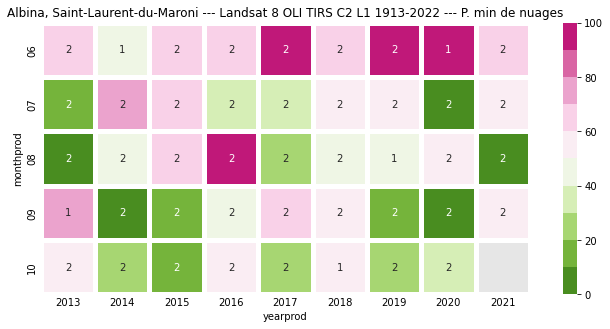

In [102]:
titre_graph = ('Albina, Saint-Laurent-du-Maroni --- '
               'Landsat 8 OLI TIRS C2 L1 1913-2022 --- P. min de nuages')
timeline_graph(
    df_min_nuages, df_count_img, titre_graph,
    fichier_png = 'exemple_SaintLaurentDuMaroni.png',
    coul_graph='PiYG_r', size=(12,5))


### Ce notebook a été créé par Cyril Bernard : cyril.bernard@ird.fr 